# propensity score
* 2020/11/22
* source from: https://microsoft.github.io/dowhy/example_notebooks/lalonde_pandas_api.html
* in python env, import R dataset
* using "dowhy"

In [ ]:
# 1. treat's format as bool type: True, False
# 2. define dowhy's data format or define dowhy's model 
# 3. calculate propensity score 
# dowhy 的 data format 超怪......

# Hw3

### import csv from R 

In [1]:
from rpy2.robjects import r as R
import pandas as pd 
import numpy as np
import dowhy.api

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib is building the font cache; this may take a moment.


In [7]:
%load_ext rpy2.ipython
#%R install.packages("Matching")
%R library(Matching)
%R data(lalonde)
%R -o lalonde
# lalonde.to_csv("lalonde.csv",index=False)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [19]:
%R data(lalonde, package="MatchIt")
%R -o lalonde

In [20]:
lalonde

,treat,age,educ,race,married,nodegree,re74,re75,re78
NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,black,0,1,0.0,0.0,289.7899
...,...,...,...,...,...,...,...,...,...
PSID425,0,18,11,white,0,1,0.0,0.0,10150.5000
PSID426,0,24,1,hispan,1,1,0.0,0.0,19464.6100
PSID427,0,21,18,white,0,0,0.0,0.0,0.0000
PSID428,0,32,5,black,1,1,0.0,0.0,187.6713


### import 

In [4]:
lalonde = pd.read_csv('lalonde.csv', index_col=0)
lalonde.head()

,treat,age,educ,race,married,nodegree,re74,re75,re78,pscore
NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460,0.638770
NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940,0.224634
NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500,0.678244
NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460,0.776324
NSW5,1,33,8,black,0,1,0.0,0.0,289.7899,0.701639


In [6]:
len(lalonde)

In [4]:
lalonde['black'] = lalonde['race'].apply(lambda x:1 if x=='black' else 0)
lalonde['hispan'] = lalonde['race'].apply(lambda x:1 if x=='hispan' else 0)
lalonde = lalonde.drop(['race', 'pscore'], axis=1)

In [7]:
lalonde.to_csv('lalonde_for_r.csv', index=False)

In [12]:
# for dowhy to calculate Causal Estimate
lalonde['treat'] = lalonde['treat'].apply(lambda x:True if x==1 else False)

In [5]:
lalonde.head()

,treat,age,educ,married,nodegree,re74,re75,re78,black,hispan
NSW1,1,37,11,1,1,0.0,0.0,9930.0460,1,0
NSW2,1,22,9,0,1,0.0,0.0,3595.8940,0,1
NSW3,1,30,12,0,0,0.0,0.0,24909.4500,1,0
NSW4,1,27,11,0,1,0.0,0.0,7506.1460,1,0
NSW5,1,33,8,0,1,0.0,0.0,289.7899,1,0


In [54]:
# Q1 
# standardized differences for all of the confounding variables (pre-matching). What is the standardized difference for married (to nearest hundredth
# smd = (x_1_mean - x_0_mean) / [(S_1^2 + S_0^2)/2]^1/2  -- difference in groups


In [95]:
xt = lalonde[lalonde['treat'] == 1 ]
xc = lalonde[lalonde['treat'] == 0 ]
q1 = (np.mean(xt['married']) - np.mean(xc['married'])) / np.sqrt(((np.var([xt['married']]) +  np.var([xc['married']]))/2))
q1

In [22]:
# Q2
# What is the raw (unadjusted) mean of real earnings in 1978 for treated subjects minus the mean of real earnings in 1978 for untreated subjects?

q2 = (np.mean(xt['re78']) - np.mean(xc['re78']))
q2

-635.0262120374209

In [8]:
# Fit a propensity score model. 
# Use a logistic regression model, where the outcome is treatment. 
# Include the 8 confounding variables in the model as predictors, with no interaction terms or non-linear terms (such as squared terms). 
# Obtain the propensity score for each subject.

# Q3
# What are the minimum and maximum values of the estimated propensity score?
from dowhy import CausalModel

# dowhy 有點不好用
# 先用 R 做一遍，理解含義，之後再看看 dowhy 怎麼用~

In [7]:
lalonde.head()

,treat,age,educ,race,married,nodegree,re74,re75,re78,pscore
NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460,0.638770
NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940,0.224634
NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500,0.678244
NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460,0.776324
NSW5,1,33,8,black,0,1,0.0,0.0,289.7899,0.701639


In [ ]:
# I. Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect()

# III. Estimate the target estimand using a statistical method.
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")

# IV. Refute the obtained estimate using multiple robustness checks.
# refute_results = model.refute_estimate(identified_estimand, estimate,
#                                        method_name="random_common_cause")

In [10]:
model= CausalModel(
        data=lalonde,
        treatment='treat',
        outcome='re78',
        common_causes=["married", "age", "educ", "black", "hispan", "nodegree", "re74", 're75'],
        proceed_when_unidentifiable=True
)
identified_estimand = model.identify_effect()

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treat'] on outcome ['re78']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['age', 'nodegree', 're74', 'black', 'married', 're75', 'U', 'educ', 'hispan']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [13]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: re78~treat+age+nodegree+re74+black+married+re75+educ+hispan
/Users/youngmihuang/anaconda3/envs/pyenv36new/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/youngmihuang/anaconda3/envs/pyenv36new/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [14]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                        
────────(Expectation(re78|age,nodegree,re74,black,married,re75,educ,hispan))
d[treat]                                                                    
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,age,nodegree,re74,black,married,re75,educ,hispan,U) = P(re78|treat,age,nodegree,re74,black,married,re75,educ,hispan)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: re78~treat+age+nodegree+re74+black+married+re75+educ+hispan
Target units: ate

## Estimate
Mean value: -431.21786304560277



In [123]:
# Non relevant of Q3 
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: re78~treat+age+black+educ+re75+married+re74+nodegree+hispan


                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     11.64
Date:                   日, 20 12 2020   Prob (F-statistic):           5.99e-17
Time:                        09:37:55   Log-Likelihood:                -6297.8
No. Observations:                 614   AIC:                         1.262e+04
Df Residuals:                     604   BIC:                         1.266e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.5145   2436.746      0.027      0.9

In [16]:
do_df = lalonde.causal.do(x={'treat': 1},
                          outcome='re78',
                          common_causes=['nodegree', 'black', 'hispan', 'age', 'educ', 'married', 're74', 're75'],
                          variable_types={'age': 'c', 'educ':'c', 'black': 'b', 'hispan':'b',
                                          'married': 'b', 'nodegree': 'b','re78': 'c', 'treat': 'b', 're74':'c', 're75':'c'})

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treat'] on outcome ['re78']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['age', 'nodegree', 're74', 'black', 'married', 're75', 'U', 'educ', 'hispan']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.
/Users/youngmihuang/anaconda3/envs/pyenv36new/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [24]:
do_df['re78'].describe()

count      445.000000
mean      5901.058712
std       7312.234095
min          0.000000
25%          0.000000
50%       3595.890000
75%       8881.670000
max      60307.900000
Name: re78, dtype: float64

In [76]:
print(max(do_df.propensity_score))
print(min(do_df.propensity_score))

0.992255417347651
0.038151505998163734


In [17]:
print(max(do_df.propensity_score))
print(min(do_df.propensity_score))

0.7577285654956103
0.04033618128838998


## treament effect estimation

In [13]:
# before by doing (未介入之前)
(lalonde[lalonde['treat'] == 1].mean() - lalonde[lalonde['treat'] == 0].mean())['re78']

In [14]:
(do_df[do_df['treat'] == 1].mean() - do_df[do_df['treat'] == 0].mean())['re78']

In [15]:
# We could get some rough error bars on the outcome using the normal approximation for a 95% confidence interval, like

import numpy as np
1.96*np.sqrt((do_df[do_df['treat'] == 1].var()/len(do_df[do_df['treat'] == 1])) +
             (do_df[do_df['treat'] == 0].var()/len(do_df[do_df['treat'] == 0])))['re78']

In [18]:
# compare 介入前與介入後
do_df['re78'].describe()

count      445.000000
mean      5937.449160
std       7346.148565
min          0.000000
25%          0.000000
50%       4196.380000
75%       9598.540000
max      60307.900000
Name: re78, dtype: float64

In [20]:
lalonde['re78'].describe()

count      445.000000
mean      5300.765138
std       6631.493362
min          0.000000
25%          0.000000
50%       3701.810000
75%       8124.720000
max      60307.900000
Name: re78, dtype: float64

/Users/youngmihuang/anaconda3/envs/pyenv36new/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


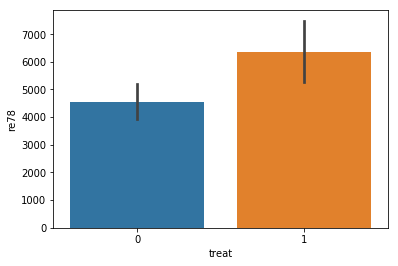

In [21]:
%matplotlib inline
import seaborn as sns

sns.barplot(data=lalonde, x='treat', y='re78')

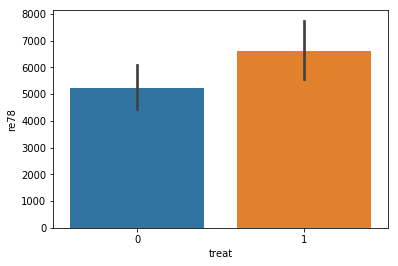

In [22]:
sns.barplot(data=do_df, x='treat', y='re78')

## specifying interventions

In [87]:
lalonde.head()

,treat,age,educ,married,nodegree,re74,re75,re78,black,hispan
NSW1,1,37,11,1,1,0.0,0.0,9930.0460,1,0
NSW2,1,22,9,0,1,0.0,0.0,3595.8940,0,1
NSW3,1,30,12,0,0,0.0,0.0,24909.4500,1,0
NSW4,1,27,11,0,1,0.0,0.0,7506.1460,1,0
NSW5,1,33,8,0,1,0.0,0.0,289.7899,1,0


## dowhy examples
* URL: https://github.com/microsoft/dowhy/blob/master/docs/source/example_notebooks/dowhy_simple_example.ipynb

In [101]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [102]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=20000, 
        treatment_is_binary=True,
        num_discrete_common_causes=1)
df = data["df"]
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])

         X0   Z0        Z1        W0        W1        W2        W3 W4    v0  \
0 -0.471926  0.0  0.612881  2.281322  0.589525  1.273016  0.707111  0  True   
1  2.469504  0.0  0.887045 -0.053649 -0.033887  1.102077  1.474735  2  True   
2 -0.106168  1.0  0.542179 -1.212161  0.810421  0.757064  0.170235  2  True   
3 -1.211935  0.0  0.796249  0.446087 -0.539440 -0.241851 -0.330753  0  True   
4  1.160383  1.0  0.907406  1.247997 -1.210418  2.088958  0.690118  0  True   

           y  
0  24.832842  
1  29.639313  
2  17.106348  
3   5.505308  
4  24.215424  
digraph { U[label="Unobserved Confounders"]; U->y;v0->y; U->v0;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}


graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[

## input casual graph

In [103]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


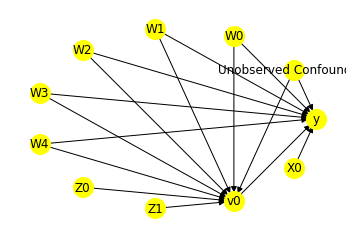

In [104]:
model.view_model()


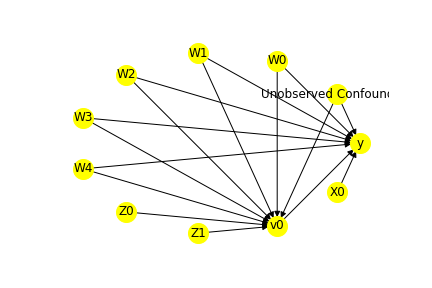

In [105]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [106]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W3', 'W4', 'Unobserved Confounders', 'W2', 'W1', 'W0']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W4,W2,W1,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W2,W1,W0,U) = P(y|v0,W3,W4,W2,W1,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)



In [107]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W4+W2+W1+W0
/Users/youngmihuang/anaconda3/envs/pyenv36new/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W4,W2,W1,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W2,W1,W0,U) = P(y|v0,W3,W4,W2,W1,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W4+W2+W1+W0
Target units: ate

## Estimate
Mean value: 10.308761757671062

Causal Estimate is 10.308761757671062


In [114]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W4+W2+W1+W0
/Users/youngmihuang/anaconda3/envs/pyenv36new/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W4,W2,W1,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W2,W1,W0,U) = P(y|v0,W3,W4,W2,W1,W0)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W4+W2+W1+W0
Target units: atc

## Estimate
Mean value: 10.480769807217099

Causal Estimate is 10.480769807217099
